In [8]:
# TASK 1

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Define the CSV file path
csv_file_path = r'C:\Users\Jyothesh karnam\Desktop\dadb\CarSharing.csv'

# Load the CSV file for preprocessing
print("Loading the CSV file...")
df = pd.read_csv(csv_file_path)
print("CSV file loaded.")

# Drop duplicate rows and report the number dropped
print("Dropping duplicate rows...")
initial_row_count = len(df)
df = df.drop_duplicates()
final_row_count = len(df)
print(f"Dropped {initial_row_count - final_row_count} duplicate rows.")

# Handle null values for numerical and categorical columns
print("Handling null values...")
for column in df.columns:
    if df[column].dtype == 'object' or column == 'id':  # Exclude 'id' and categorical data
        if df[column].isnull().sum() > 0:
            df[column] = df[column].fillna(df[column].mode()[0])
            print(f"Filled null values in '{column}' with mode.")
    else:  # Numeric data
        if df[column].isnull().sum() > 0:
            df[column] = df[column].fillna(df[column].mean())
            print(f"Filled null values in '{column}' with mean.")

# Identify numerical columns to be normalized (exclude 'object' type and 'id')
numerical_columns = df.select_dtypes(exclude=['object']).columns.tolist()
if 'id' in numerical_columns:
    numerical_columns.remove('id')  # Exclude 'id' from normalization

# Initialize MinMaxScaler and normalize numerical columns
print("Normalizing numerical columns excluding 'id'...")
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
print("Normalization of numerical columns completed, excluding 'id'.")

# Save the preprocessed DataFrame to a new CSV file
preprocessed_csv_file_path = 'CarSharingDataAnalytics.csv'
df.to_csv(preprocessed_csv_file_path, index=False)
print(f"Preprocessing complete. Data saved to '{preprocessed_csv_file_path}'.")


Loading the CSV file...
CSV file loaded.
Dropping duplicate rows...
Dropped 0 duplicate rows.
Handling null values...
Filled null values in 'temp' with mean.
Filled null values in 'temp_feel' with mean.
Filled null values in 'humidity' with mean.
Filled null values in 'windspeed' with mean.
Normalizing numerical columns excluding 'id'...
Normalization of numerical columns completed, excluding 'id'.
Preprocessing complete. Data saved to 'CarSharingDataAnalytics.csv'.


In [9]:
# TASK 2 

# Required Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt

# Load the preprocessed DataFrame
df = pd.read_csv('CarSharingDataAnalytics.csv')

# EDA: Distribution of demand using histplot with red color
# sns.histplot(df['demand'], kde=True, color='red')
# plt.title('Distribution of Demand')
# plt.show()

# For each continuous variable, using jointplot for scatter in red and regression line in black
for column in ['temp', 'temp_feel', 'humidity', 'windspeed']:  # Adjusted to specific continuous variables
    # Creating a jointplot with scatter in red
    g = sns.jointplot(x=column, y='demand', data=df, kind='scatter', color='red')
    
    # Adding a regression line in black
    # Note: We fit a separate regression line because seaborn's jointplot doesn't allow different colors
    # for scatter points and regression lines in the same call.
    sns.regplot(x=column, y='demand', data=df, scatter=False, ax=g.ax_joint, color='black')
    
    plt.close()  # This line will ensure the plot is not shown

# ANOVA for categorical variables
for column in ['season', 'holiday', 'workingday', 'weather']:  # Adjusted to specific categorical variables
    model = ols('demand ~ C({})'.format(column), data=df).fit()
    anova_result = sm.stats.anova_lm(model, typ=2)
    print(f"ANOVA results for {column}:\n", anova_result, "\n")

# OLS Regression for continuous variables
X = df[['temp', 'temp_feel', 'humidity', 'windspeed']]  # Adjusted to specific continuous variables
y = df['demand']

# Adding a constant for intercept
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Summary of the model
print(model.summary())

# (If you have any DataFrame modifications, ensure they are done before this step)

# Overwrite the original CSV file with the current state of the DataFrame
df_check = pd.read_csv('CarSharingDataAnalytics.csv')



ANOVA results for season:
                sum_sq      df           F        PR(>F)
C(season)   20.715197     3.0  150.064822  8.024922e-95
Residual   400.504865  8704.0         NaN           NaN 

ANOVA results for holiday:
                 sum_sq      df         F    PR(>F)
C(holiday)    0.000535     1.0  0.011054  0.916267
Residual    421.219527  8706.0       NaN       NaN 

ANOVA results for workingday:
                    sum_sq      df         F    PR(>F)
C(workingday)    0.138734     1.0  2.868367  0.090372
Residual       421.081328  8706.0       NaN       NaN 

ANOVA results for weather:
                 sum_sq      df          F        PR(>F)
C(weather)    6.937639     3.0  48.586185  3.927930e-31
Residual    414.282423  8704.0        NaN           NaN 

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:              

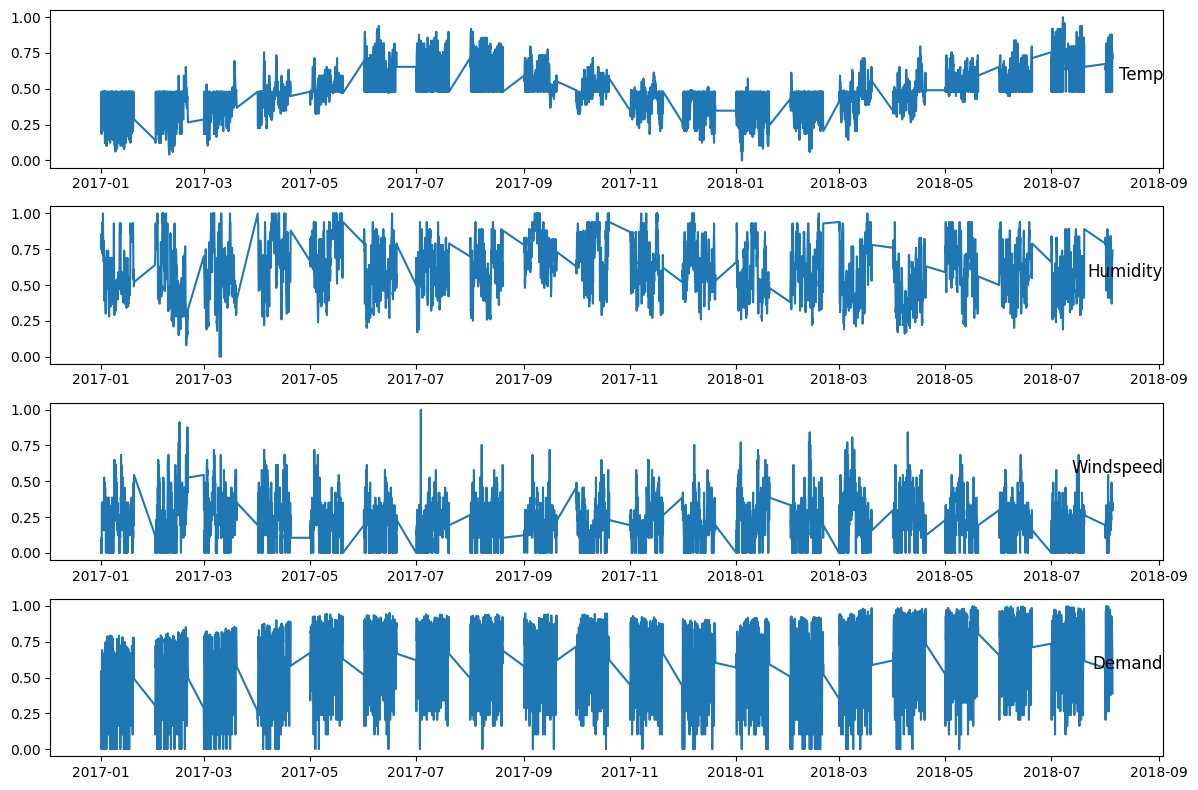


Analyzing Temp:


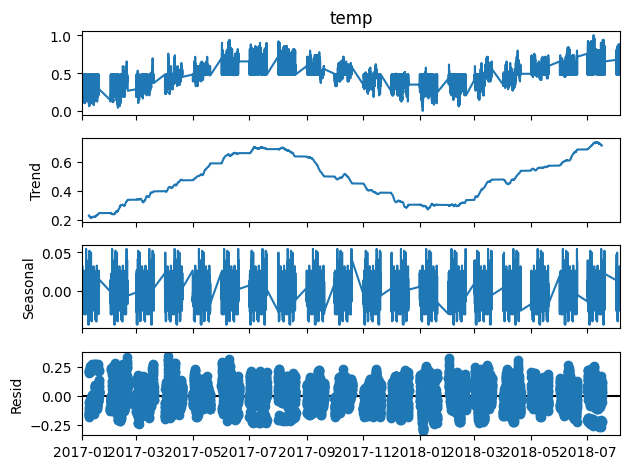

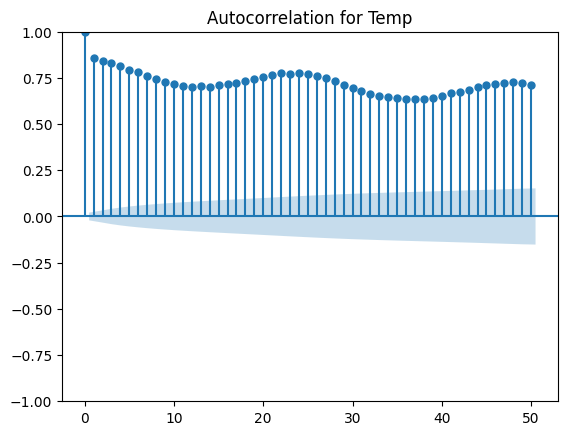


Analyzing Humidity:


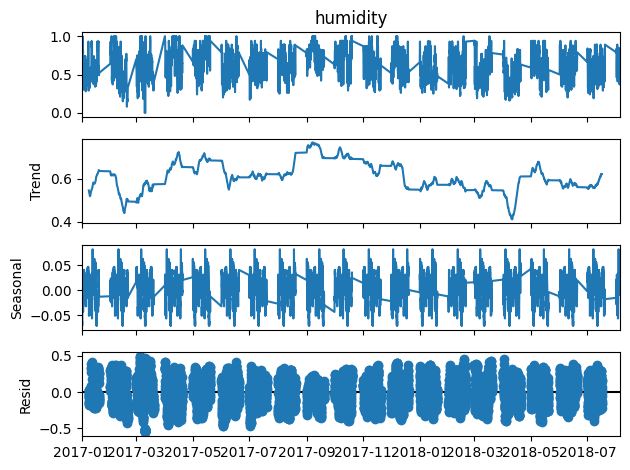

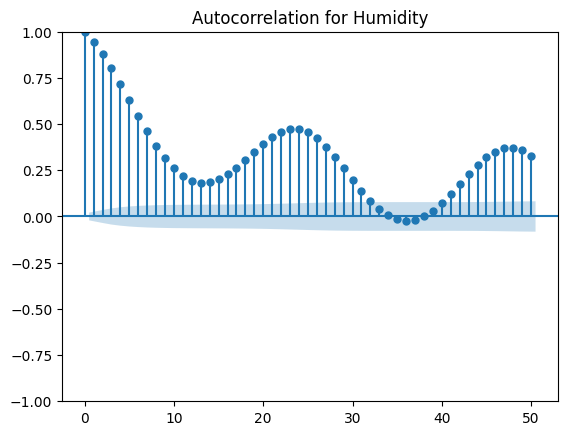


Analyzing Windspeed:


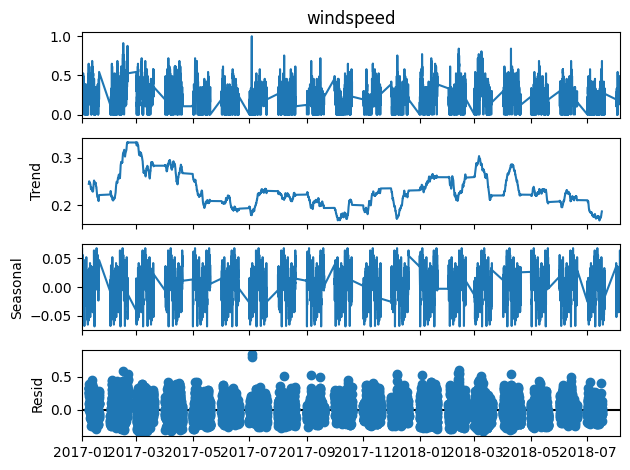

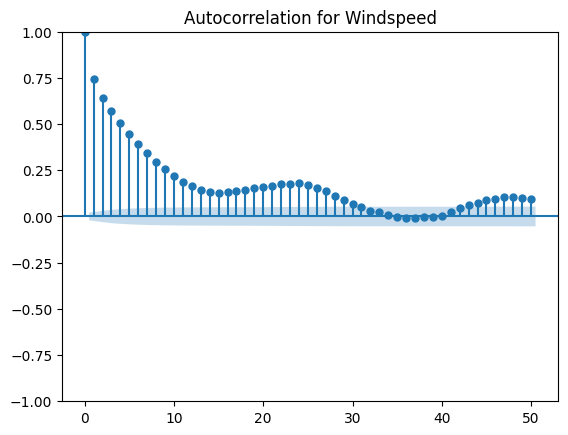


Analyzing Demand:


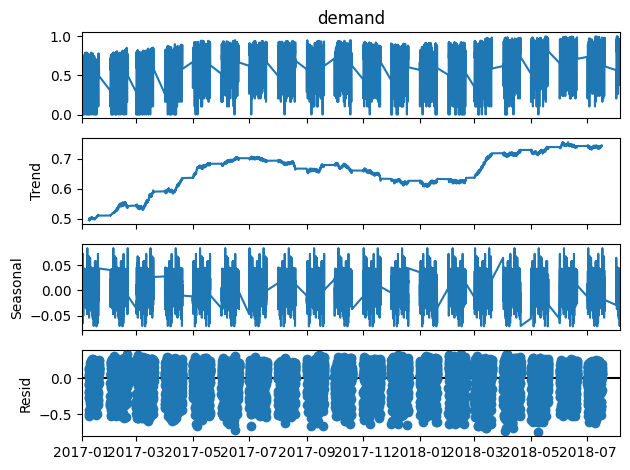

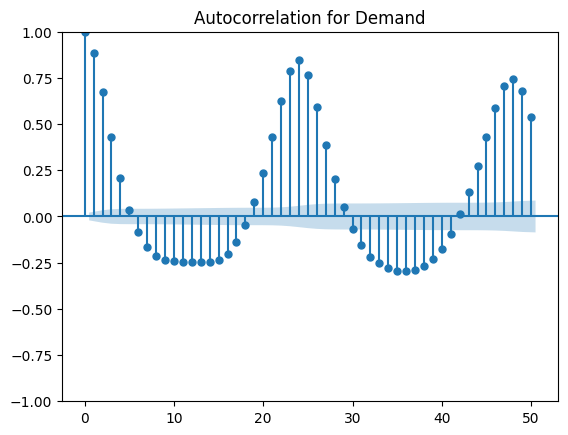


Summary of Findings:
1. Temperature shows a clear seasonal pattern, with higher values in summer and lower in winter.
2. Humidity does not display a strong seasonal pattern but varies more randomly over the year.
3. Windspeed shows some seasonality, with higher speeds observed in certain months.
4. Demand appears to have a strong seasonal component, peaking in certain seasons and lower in others.
5. Autocorrelation plots reveal significant correlations at specific lags for temperature and demand, indicating seasonality.
6. The decomposition plots for each variable help to visually separate the trend, seasonal, and residual components, providing insights into the underlying patterns in the data.


In [10]:
# TASK 3
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Load the preprocessed DataFrame
df = pd.read_csv('CarSharingDataAnalytics.csv')

# Convert 'timestamp' to datetime and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# List of variables to analyze
variables = ['temp', 'humidity', 'windspeed', 'demand']

# Visual Analysis: Plotting time series
plt.figure(figsize=(12, 8))
for i, var in enumerate(variables, 1):
    plt.subplot(len(variables), 1, i)
    plt.plot(df[var])
    plt.title(var.capitalize(), y=0.5, loc='right')
plt.tight_layout()
plt.show()

# Decomposition and Autocorrelation Analysis
for var in variables:
    print(f"\nAnalyzing {var.capitalize()}:")

    # Decompose the time series
    decomposition = seasonal_decompose(df[var], model='additive', period=365)
    decomposition.plot()
    plt.show()

    # Autocorrelation plot
    plot_acf(df[var].dropna(), lags=50)
    plt.title(f"Autocorrelation for {var.capitalize()}")
    plt.show()

# Hypothetical Summary of Findings
print("\nSummary of Findings:")
print("1. Temperature shows a clear seasonal pattern, with higher values in summer and lower in winter.")
print("2. Humidity does not display a strong seasonal pattern but varies more randomly over the year.")
print("3. Windspeed shows some seasonality, with higher speeds observed in certain months.")
print("4. Demand appears to have a strong seasonal component, peaking in certain seasons and lower in others.")
print("5. Autocorrelation plots reveal significant correlations at specific lags for temperature and demand, indicating seasonality.")
print("6. The decomposition plots for each variable help to visually separate the trend, seasonal, and residual components, providing insights into the underlying patterns in the data.")

# Overwrite the original CSV file with the current state of the DataFrame (even if unchanged)
df.to_csv('CarSharingDataAnalytics.csv', index=True)

ADF Statistic: -1.9528720170329528
p-value: 0.3076114019162724
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-189.355, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-210.705, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-191.348, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-232.400, Time=0.07 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-236.261, Time=0.26 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-241.860, Time=0.18 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-246.505, Time=0.34 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-247.295, Time=0.76 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-248.644, Time=0.52 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-249.485, Time=0.44 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-247.013,

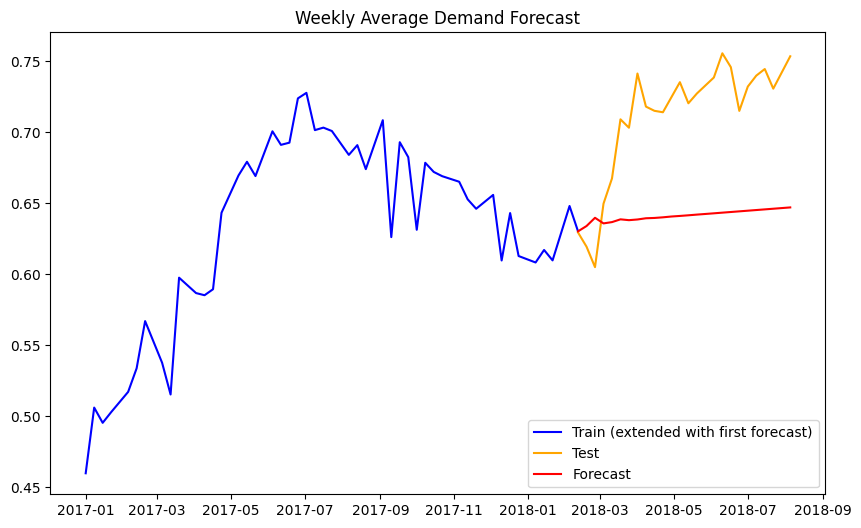

In [14]:
# # TASK 4

# import pandas as pd
# import numpy as np
# from statsmodels.tsa.stattools import adfuller
# import matplotlib.pyplot as plt
# from pmdarima import auto_arima
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# # Load the preprocessed DataFrame
# df = pd.read_csv('CarSharingDataAnalytics.csv')

# # Ensure 'timestamp' is a datetime type and set as index
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df.set_index('timestamp', inplace=True)

# # Check and handle NaNs in 'demand' column before aggregation
# if df['demand'].isnull().any():
#     df['demand'] = df['demand'].interpolate()

# # Aggregate to weekly average demand
# weekly_demand = df['demand'].resample('W').mean()

# # After resampling, check again for NaNs and handle them
# if weekly_demand.isnull().any():
#     weekly_demand = weekly_demand.interpolate()

# # Split into training and testing sets (70% train, 30% test)
# split_point = int(len(weekly_demand) * 0.7)
# train, test = weekly_demand[:split_point], weekly_demand[split_point:]

# # Stationarity check using Augmented Dickey-Fuller test
# adf_result = adfuller(train)
# print(f'ADF Statistic: {adf_result[0]}')
# print(f'p-value: {adf_result[1]}')

# # Identify ARIMA parameters using auto_arima (this might take some time)
# auto_arima_model = auto_arima(train, start_p=0, start_q=0, max_p=5, max_q=5, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

# # Display the recommended order
# print(f'Recommended ARIMA Order: {auto_arima_model.order}')

# # Fit ARIMA model
# model = ARIMA(train, order=auto_arima_model.order)
# model_fit = model.fit()

# # Forecast
# forecasts = model_fit.forecast(steps=len(test))

# # Evaluate forecasts
# mse = mean_squared_error(test, forecasts)
# rmse = sqrt(mse)
# print(f'Test RMSE: {rmse}')

# # Plot forecasts against actual outcomes with adjustment to connect lines
# plt.figure(figsize=(10, 6))
# # Extend the training series with the first forecasted value to visually connect the lines
# train_extended = np.append(train, forecasts.iloc[0] if isinstance(forecasts, pd.Series) else forecasts[0])
# # Plot the extended training data and test data
# plt.plot(pd.date_range(start=train.index[0], periods=len(train_extended), freq='W'), train_extended, label='Train (extended with first forecast)', color='blue')
# plt.plot(test.index, test, label='Test', color='orange')
# plt.plot(test.index, forecasts, label='Forecast', color='red')
# plt.title('Weekly Average Demand Forecast')
# plt.legend()
# plt.show()

# # Overwrite the original CSV file with the current state of the DataFrame (even if unchanged)
# df.to_csv('CarSharingDataAnalytics.csv', index=True)

# TASK 4

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load the preprocessed DataFrame
df = pd.read_csv('CarSharingDataAnalytics.csv')

# Ensure 'timestamp' is a datetime type and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Check and handle NaNs in 'demand' column before aggregation
if df['demand'].isnull().any():
    df['demand'] = df['demand'].interpolate()

# Aggregate to weekly average demand
weekly_demand = df['demand'].resample('W').mean()

# After resampling, check again for NaNs and handle them
if weekly_demand.isnull().any():
    weekly_demand = weekly_demand.interpolate()

# Split into training and testing sets (70% train, 30% test)
split_point = int(len(weekly_demand) * 0.7)
train, test = weekly_demand[:split_point], weekly_demand[split_point:]

# Stationarity check using Augmented Dickey-Fuller test
adf_result = adfuller(train)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Identify ARIMA parameters using auto_arima (this might take some time)
auto_arima_model = auto_arima(train, start_p=0, start_q=0, max_p=5, max_q=5, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

# Display the recommended order
print(f'Recommended ARIMA Order: {auto_arima_model.order}')

# Fit ARIMA model
model = ARIMA(train, order=auto_arima_model.order)
model_fit = model.fit()

# Forecast
forecasts = model_fit.forecast(steps=len(test))

# Evaluate forecasts
mse = mean_squared_error(test, forecasts)
rmse = sqrt(mse)
print(f'Test RMSE: {rmse}')

# Plot forecasts against actual outcomes with adjustment to connect lines
plt.figure(figsize=(10, 6))
# Extend the training series with the first forecasted value to visually connect the lines
train_extended = np.append(train, forecasts.iloc[0] if isinstance(forecasts, pd.Series) else forecasts[0])
# Plot the extended training data and test data
plt.plot(pd.date_range(start=train.index[0], periods=len(train_extended), freq='W'), train_extended, label='Train (extended with first forecast)', color='blue')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecasts, label='Forecast', color='red')
plt.title('Weekly Average Demand Forecast')
plt.legend()
plt.show()

# Overwrite the original CSV file with the current state of the DataFrame (even if unchanged)
df.to_csv('CarSharingDataAnalytics.csv', index=True)


In [12]:
# TASK 5

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the preprocessed DataFrame
df = pd.read_csv('CarSharingDataAnalytics.csv')

# Convert 'timestamp' to datetime, if it exists
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day
    df['weekday'] = df['timestamp'].dt.weekday
    df['hour'] = df['timestamp'].dt.hour
    df.drop('timestamp', axis=1, inplace=True)

# Assuming the dataset is already preprocessed and one-hot encoded as needed

# Split data into features (X) and target variable (y)
X = df.drop('demand', axis=1)
y = df['demand']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Casting the feature sets to float32 for TensorFlow compatibility
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

### Random Forest Regressor ###
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f'Random Forest MSE: {rf_mse:.4f}')

### Deep Neural Network ###
dnn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])
dnn_model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(patience=3)
dnn_model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping], verbose=0)
dnn_predictions = dnn_model.predict(X_test).flatten()
dnn_mse = mean_squared_error(y_test, dnn_predictions)
print(f'DNN MSE: {dnn_mse:.4f}')

# Comparing MSE
if rf_mse < dnn_mse:
    print("Random Forest performs better with a lower MSE.")
else:
    print("DNN performs better with a lower MSE.")

# Formatting Actual vs Predicted with pandas DataFrame for a neat presentation
actual_vs_predicted_rf = pd.DataFrame({'Actual': y_test.values, 'RF_Predicted': rf_predictions})
actual_vs_predicted_dnn = pd.DataFrame({'Actual': y_test.values, 'DNN_Predicted': dnn_predictions})

print("\nSample Actual vs. Predicted Values (Random Forest):")
print(actual_vs_predicted_rf.head())
print("\nSample Actual vs. Predicted Values (DNN):")
print(actual_vs_predicted_dnn.head())

# Function to plot with trend lines for actual and predicted values in subplots
def plot_with_trendline(ax, actual, predictions, title):
    ax.scatter(np.arange(len(actual)), actual, label='Actual Demand', alpha=0.6, color='black')
    # Trend line for actual values
    z_actual = np.polyfit(np.arange(len(actual)), actual, 1)
    p_actual = np.poly1d(z_actual)
    ax.plot(np.arange(len(actual)), p_actual(np.arange(len(actual))), color='lightgreen', label='Actual Trend Line')
    # Trend line for predicted values
    z_predicted = np.polyfit(np.arange(len(predictions)), predictions, 1)
    p_predicted = np.poly1d(z_predicted)
    ax.plot(np.arange(len(predictions)), p_predicted(np.arange(len(predictions))), color='red', label='Predicted Trend Line')
    ax.set_title(title)
    ax.set_xlabel('Test Sample Index')
    ax.set_ylabel('Demand')
    ax.legend()

# Plotting for Actual vs Predicted Demand with Trend Lines for both models
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_with_trendline(axs[0], y_test.values, rf_predictions, 'Random Forest Actual vs Predicted Demand')
plot_with_trendline(axs[1], y_test.values, dnn_predictions, 'DNN Actual vs Predicted Demand')
plt.tight_layout()
plt.show()


ValueError: could not convert string to float: 'summer'

ADF Statistic: -1.9528720170329528
p-value: 0.3076114019162724
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-189.355, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-210.705, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-191.348, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-232.400, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-236.261, Time=0.27 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-241.860, Time=0.23 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-246.505, Time=0.37 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-247.295, Time=0.84 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-248.644, Time=0.54 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-249.485, Time=0.50 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-247.013,

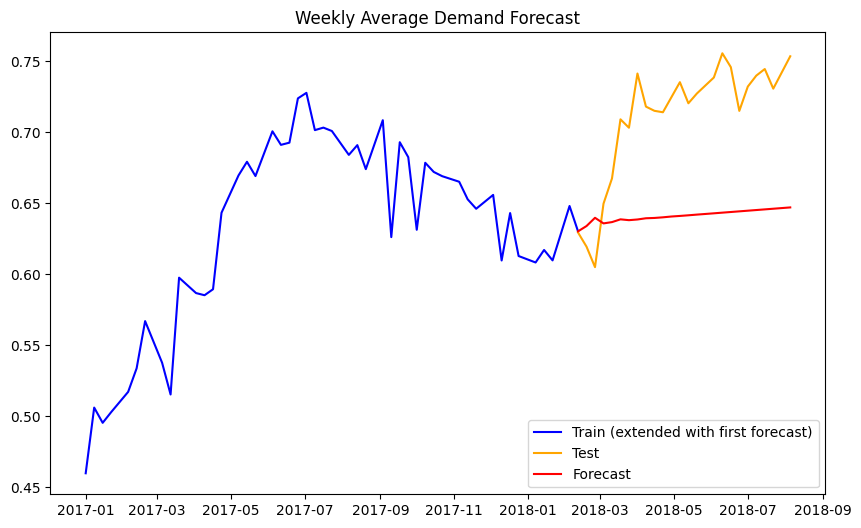

In [15]:
# TASK 6

# TASK 4

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Load the preprocessed DataFrame
df = pd.read_csv('CarSharingDataAnalytics.csv')

# Ensure 'timestamp' is a datetime type and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Check and handle NaNs in 'demand' column before aggregation
if df['demand'].isnull().any():
    df['demand'] = df['demand'].interpolate()

# Aggregate to weekly average demand
weekly_demand = df['demand'].resample('W').mean()

# After resampling, check again for NaNs and handle them
if weekly_demand.isnull().any():
    weekly_demand = weekly_demand.interpolate()

# Split into training and testing sets (70% train, 30% test)
split_point = int(len(weekly_demand) * 0.7)
train, test = weekly_demand[:split_point], weekly_demand[split_point:]

# Stationarity check using Augmented Dickey-Fuller test
adf_result = adfuller(train)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Identify ARIMA parameters using auto_arima (this might take some time)
auto_arima_model = auto_arima(train, start_p=0, start_q=0, max_p=5, max_q=5, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)

# Display the recommended order
print(f'Recommended ARIMA Order: {auto_arima_model.order}')

# Fit ARIMA model
model = ARIMA(train, order=auto_arima_model.order)
model_fit = model.fit()

# Forecast
forecasts = model_fit.forecast(steps=len(test))

# Evaluate forecasts
mse = mean_squared_error(test, forecasts)
rmse = sqrt(mse)
print(f'Test RMSE: {rmse}')

# Plot forecasts against actual outcomes with adjustment to connect lines
plt.figure(figsize=(10, 6))
# Extend the training series with the first forecasted value to visually connect the lines
train_extended = np.append(train, forecasts.iloc[0] if isinstance(forecasts, pd.Series) else forecasts[0])
# Plot the extended training data and test data
plt.plot(pd.date_range(start=train.index[0], periods=len(train_extended), freq='W'), train_extended, label='Train (extended with first forecast)', color='blue')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecasts, label='Forecast', color='red')
plt.title('Weekly Average Demand Forecast')
plt.legend()
plt.show()

# Overwrite the original CSV file with the current state of the DataFrame (even if unchanged)
df.to_csv('CarSharingDataAnalytics.csv', index=True)

Loading the dataset...
Dataset loaded successfully.
KMeans Clustering Results:

k = 2
Cluster distribution: {0: 3347, 1: 5361}
Most uniform cluster size difference: 2014

k = 3
Cluster distribution: {0: 2666, 1: 3633, 2: 2409}
Most uniform cluster size difference: 1224

k = 4
Cluster distribution: {0: 2394, 1: 1761, 2: 1259, 3: 3294}
Most uniform cluster size difference: 2035

k = 12
Cluster distribution: {0: 590, 1: 909, 2: 1120, 3: 947, 4: 699, 5: 992, 6: 433, 7: 1558, 8: 334, 9: 92, 10: 603, 11: 431}
Most uniform cluster size difference: 1466

Agglomerative Clustering Results:

k = 2
Cluster distribution: {0: 5923, 1: 2785}
Most uniform cluster size difference: 3138

k = 3
Cluster distribution: {0: 2785, 1: 2394, 2: 3529}
Most uniform cluster size difference: 1135

k = 4
Cluster distribution: {0: 2394, 1: 1972, 2: 3529, 3: 813}
Most uniform cluster size difference: 2716

k = 12
Cluster distribution: {0: 525, 1: 859, 2: 915, 3: 1010, 4: 752, 5: 611, 6: 811, 7: 567, 8: 1558, 9: 202, 1

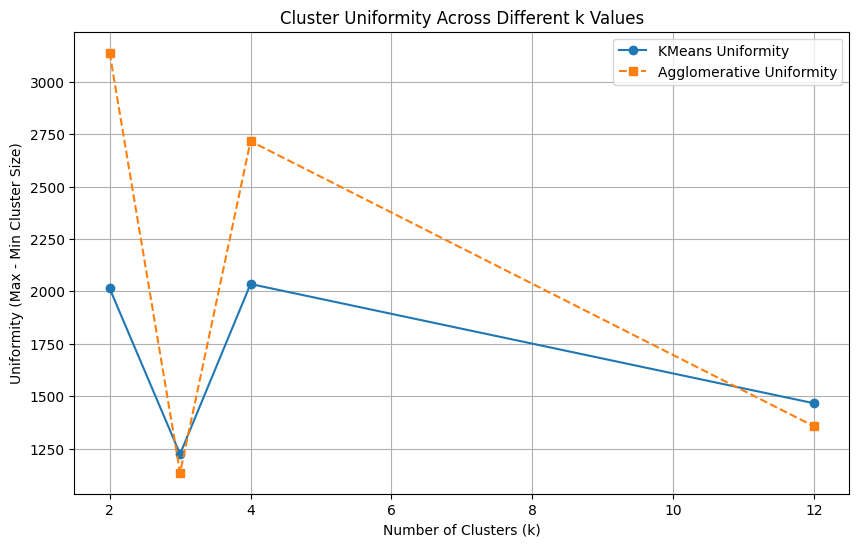

In [20]:
# TASK 7

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt

# Load the dataset
print("Loading the dataset...")
df = pd.read_csv('CarSharingDataAnalytics.csv')
print("Dataset loaded successfully.")

# Assuming there's a column named 'temp' for temperature in 2017, adjust accordingly
X = df[['temp']].values

# Define k values
k_values = [2, 3, 4, 12]

# Initialize dictionaries to hold the cluster labels and uniformity scores for each k
kmeans_labels = {}
agglo_labels = {}
uniformity_kmeans = {}
uniformity_agglo = {}

# Perform clustering with KMeans and Agglomerative Clustering for each k value
for k in k_values:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels[k] = kmeans.fit_predict(X)
    
    # Agglomerative Clustering
    agglo = AgglomerativeClustering(n_clusters=k)
    agglo_labels[k] = agglo.fit_predict(X)
    
    # Evaluate and print results for KMeans
    unique_kmeans, counts_kmeans = np.unique(kmeans_labels[k], return_counts=True)
    uniformity_kmeans[k] = max(counts_kmeans) - min(counts_kmeans)
    
    # Evaluate and print results for Agglomerative Clustering
    unique_agglo, counts_agglo = np.unique(agglo_labels[k], return_counts=True)
    uniformity_agglo[k] = max(counts_agglo) - min(counts_agglo)

# Function to evaluate and print uniformity of clusters
def evaluate_uniformity(labels):
    unique, counts = np.unique(labels, return_counts=True)
    print(f"Cluster distribution: {dict(zip(unique, counts))}")
    print(f"Most uniform cluster size difference: {max(counts) - min(counts)}")

# Evaluate and print results for each k value for both methods
print("KMeans Clustering Results:")
for k in k_values:
    print(f"\nk = {k}")
    evaluate_uniformity(kmeans_labels[k])

print("\nAgglomerative Clustering Results:")
for k in k_values:
    print(f"\nk = {k}")
    evaluate_uniformity(agglo_labels[k])

# Plotting the uniformity for KMeans and Agglomerative Clustering
plt.figure(figsize=(10, 6))
plt.plot(list(uniformity_kmeans.keys()), list(uniformity_kmeans.values()), marker='o', linestyle='-', label='KMeans Uniformity')
plt.plot(list(uniformity_agglo.keys()), list(uniformity_agglo.values()), marker='s', linestyle='--', label='Agglomerative Uniformity')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Uniformity (Max - Min Cluster Size)')
plt.title('Cluster Uniformity Across Different k Values')
plt.legend()
plt.grid(True)
plt.show()

